In [1]:
%matplotlib inline

from warnings import filterwarnings

from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [2]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

モデルはrandom variables (RVs) への参照をもち、logpやその勾配を計算する。

In [12]:
model.basic_RVs, model.free_RVs, model.observed_RVs

([mu, obs], [mu], [obs])

In [13]:
# log probability density function
model.logp({'mu': 0})

array(-155.78695688)

In [23]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)

x.logp({'x': 0})

array(-0.91893853)

PyMC3では制約ありのRVsは制約なしになるように自動的に変換される。  
include_transformed=Trueを引数に与えることで、変換後のパラメータの結果も表示されるようになる。

In [11]:
with pm.Model() as model:
    x = pm.Gamma('x', mu=1, sd=1)
    y = pm.Uniform('y', lower=-1, upper=2)
    z = pm.Deterministic('z', x + y)
    
model.free_RVs

[x_log__, y_interval__]

In [15]:
model.deterministics

[x, y, z]

### 初期値の設定  
基本的に初期値は自動的に設定されるが、手動で変更することも可能。

In [17]:
# initial values
with pm.Model():
    x = pm.Normal('x', mu=1, sd=2, shape=5)

x.tag.test_value

array([1., 1., 1., 1., 1.])

In [27]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([ 0.89674484,  0.3252694 , -0.24739399,  0.77750987,  0.30550593])

### サンプリング
NUTSでは良い初期値を探索するために、変分推論などを用いる。  
NUTSでのサンプリングが難しい場合、メトロポリス法を使っても改善することは少なく、初期値やパラメータを調整する方が良い。

In [18]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CSG',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SGFS',
 'SMC',
 'Slice']

### 変分推論

In [21]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    pm.NormalMixture('x', w=w, mu=mu, ｓｄ=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.))

100%|██████████| 10000/10000 [00:54<00:00, 184.92it/s]


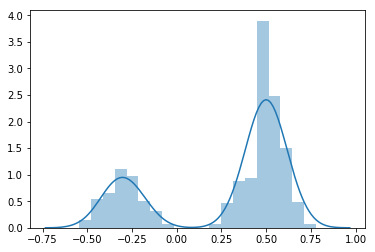

In [22]:
plt.figure()
trace = approx.sample(10000)
sns.distplot(trace['x']);

### デバッグ
theanoのprinting.Printを用いる。

Only 5 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/pymc3/sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


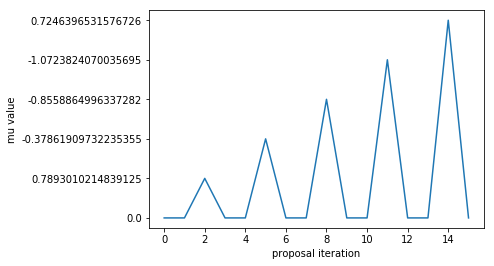

In [24]:
from io import StringIO
import theano.tensor as tt
import sys

x = np.random.randn(100)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)

    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sd=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

sys.stdout = old_stdout

output = mystdout.getvalue().split('\n')
mulines = [s for s in output if 'mu' in s]

muvals = [line.split()[-1] for line in mulines]
plt.plot(np.arange(0, len(muvals)), muvals)
plt.xlabel('proposal iteration')
plt.ylabel('mu value');

### Mass matrix

HMC法のパラメータは３つ。

1. discretization time  ϵ
2. mass matrix  Σ−1
3. number of steps taken  L

